In [1]:
import os,sys,inspect
 
os.chdir('../')

from detector.detector import *
from preprocessing.deconvolution import *
from simulator.utils import *
import numpy as np
import matplotlib.pyplot as plt
from images import *
import imageio
from PIL import Image
from simulator.utils import *
from ipywidgets import interactive, interact
import ipywidgets as widgets

Richardson-Lucy Deconvolution Versus Wiener Deconvolution
=====================================================
In this notebook we implement the Richardson-Lucy Deconvolution and the Wiener Deconvolution. We perform a comparison between the two algorithms to see which one is more suitable for deconvolving simulated atoms florescent images

In [3]:
"""
tasks:
1. implement richardson lucy algorithm, test it on blurred images
2. test it on atom images
3. implement wiener filtering
3. test it on atom and some blurred images
5. evaluate which one is better for photon shot noise """

'\ntasks:\n1. implement richardson lucy algorithm, test it on blurred images\n2. test it on atom images\n3. implement wiener filtering\n3. test it on atom and some blurred images\n5. evaluate which one is better for photon shot noise '

1) convolution test
------------------
We will show that the convolution of delta functions with gaussians are gaussians at these points. So if we apply deconvolution to the gaussian shaped atom signals, we should expect to obtain dots.

In [2]:
from scipy.signal import convolve2d
img_size = 100

def original_img(img_size, x0, y0):
    img = np.zeros((img_size, img_size))
    for i in range(len(x0)):
        x = int(x0[i])
        y = int(y0[i])
        img[x, y] = 1
    return img



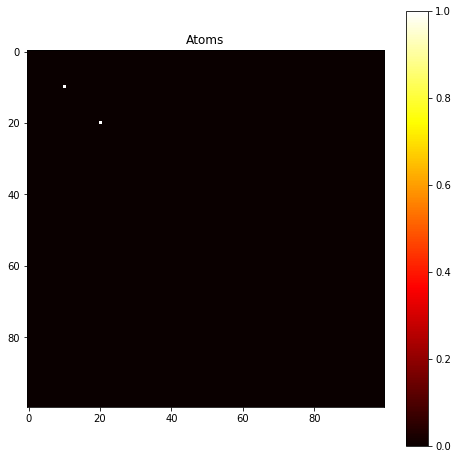

In [3]:
x0 = np.linspace(10, 90, 9)
y0 = np.linspace(10, 90, 9)
x0 = x0[0:2]
y0 = y0[0:2]
img = original_img(100, x0, y0)

plt.figure(figsize=(8,8))
plt.title("Atoms")
plt.imshow(img, cmap='hot')
plt.colorbar()
plt.show()

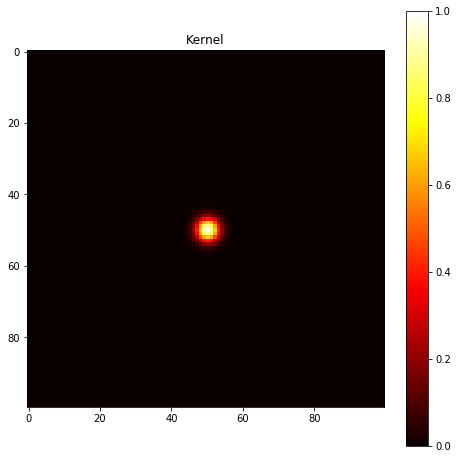

In [4]:
# kernel = np.zeros((img_size, img_size))
x = y = np.linspace(0, img_size-1, img_size)
xgrid, ygrid = np.meshgrid(x, y)  
kernel = gaussian(xgrid, ygrid, img_size//2, img_size//2, simulator.variance)

plt.figure(figsize=(8,8))
plt.title("Kernel")
plt.imshow(kernel, cmap='hot')
plt.colorbar()
plt.show()

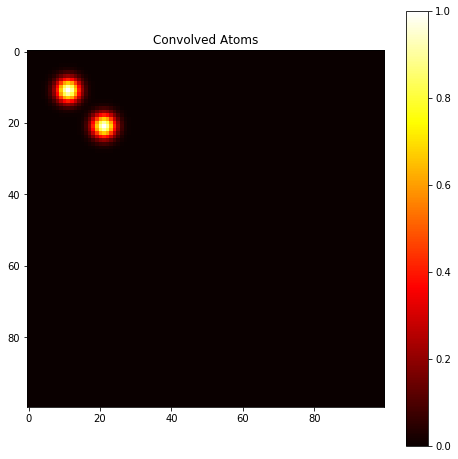

In [5]:
convolved_img = convolve2d(img, kernel, mode='same')

plt.figure(figsize=(8,8))
plt.title("Convolved Atoms")
plt.imshow(convolved_img, cmap='hot')
plt.colorbar()
plt.show()

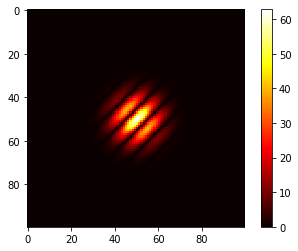

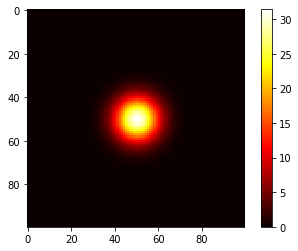

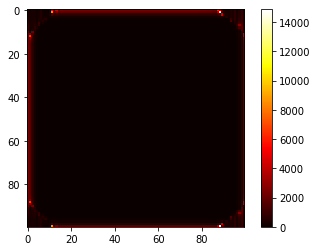

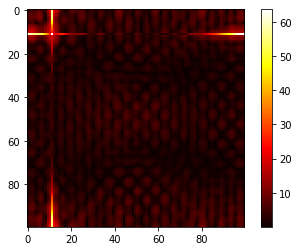

In [6]:
# deconvolution
convolved_img_fourier = np.fft.fftshift(np.fft.fft2(convolved_img))
plt.imshow(np.abs(convolved_img_fourier), cmap='hot')
plt.colorbar()
plt.show()
kernel_fourier = np.fft.fftshift(np.fft.fft2(kernel))
# plt.subplot(1, 3, 2)
plt.imshow(np.abs(kernel_fourier), cmap='hot')
plt.colorbar()
plt.show()
plt.imshow(np.abs(convolved_img_fourier / kernel_fourier), cmap='hot')
plt.colorbar()


plt.show()

img1 = np.fft.fftshift(np.fft.ifft2(convolved_img_fourier / kernel_fourier))
# a = np.fft.ifft2(convolved_img_fourier / kernel_fourier)
plt.imshow(np.abs(img1), cmap='hot')
plt.colorbar()


plt.show()

In [9]:
print(convolved_img_fourier[0, 0])
print(kernel_fourier[0, 0])

(2.6484606209673307e-13+2.128707616502344e-17j)
(-6.641510072011367e-16+1.8643731429756987e-16j)


In [110]:
a = convolved_img_fourier[0, 0]
b = kernel_fourier[0, 0]
np.abs(a / b)

100411717.20939548

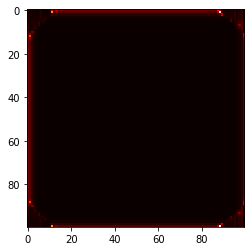

In [120]:
A = np.abs(convolved_img_fourier / kernel_fourier)
A[50, 50]
plt.imshow(A, cmap='hot')

2) Inverse Filtering
------------------------
An image can be modeled by
$$g_2 = g_1 * h + n$$
Where $g_1$ is the object, $h$ is the point spread function, ad $n$ is the shot noise. 
Applying a Fourier transform to both sides, 
$$G_2 = G_1 \cdot H + N$$
Where $H$ is now called the optical transfer function.
We can estimate $H$ by a Gaussian, then, to obtain $g_1$, we calculate
$$G_1 + \frac{N}{H} = \frac{G_2}{H}$$
applying an inverse Fourier transform, we should obtain a crude estimate of $g_1$ (it is actually $g_1 + F[\frac{N}{H}]$) we are getting back.

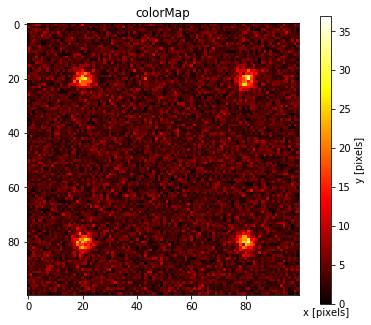

Instance info:
img_size: 100
exposure_time: 1
atom_variance: 5
quantum_efficiency: 1
atom count: 4
photons_in_background is set to 1 by default
SNR: 20
x0: [20 20 80 80]
y0: [80 20 80 20]


In [7]:
img_size = 100
SNR = 20
sim = simulator(img_size, 1)
x0 = np.array([20, 20, 80, 80])
y0 = np.array([80, 20, 80, 20])
# x0 = x0[0]
# y0 = y0[0]
g2 = sim.create_simulation_from_SNR(x0, y0, SNR, verbose=True)

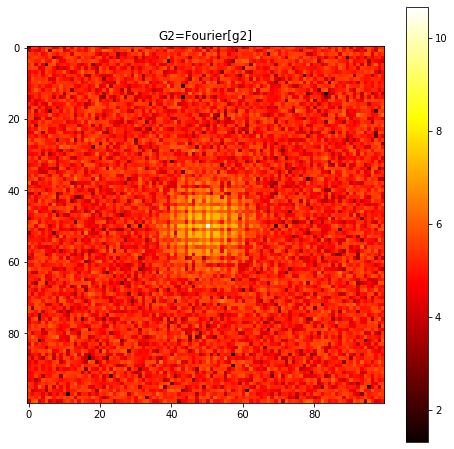

In [8]:
G2 = np.fft.fftshift(np.fft.fft2(g2))
plt.figure(figsize=(8,8))
plt.title("G2=Fourier[g2]")
plt.imshow(np.log(np.abs(G2)+1e-8), cmap='hot')
plt.colorbar()
plt.show()

In [146]:
# sss = np.fft.ifft2(G2)
# plt.imshow(np.abs(sss), cmap='hot')

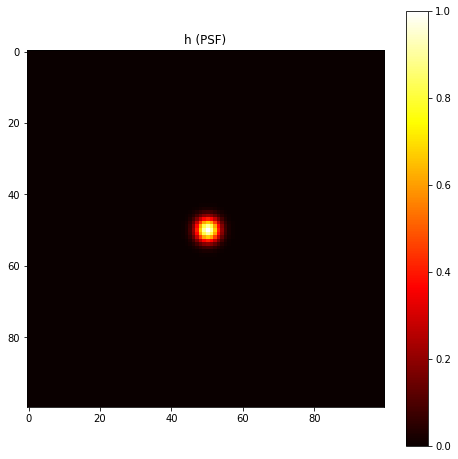

In [9]:
x = y = np.linspace(0, img_size-1, img_size)
xgrid, ygrid = np.meshgrid(x, y)  
h = gaussian(xgrid, ygrid, img_size//2, img_size//2, simulator.variance)

plt.figure(figsize=(8,8))
plt.title("h (PSF)")
plt.imshow(kernel, cmap='hot')
plt.colorbar()
plt.show()

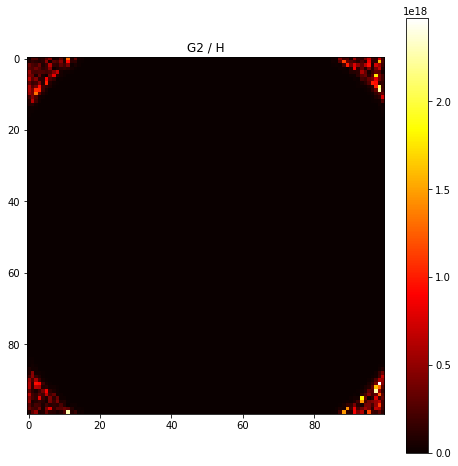

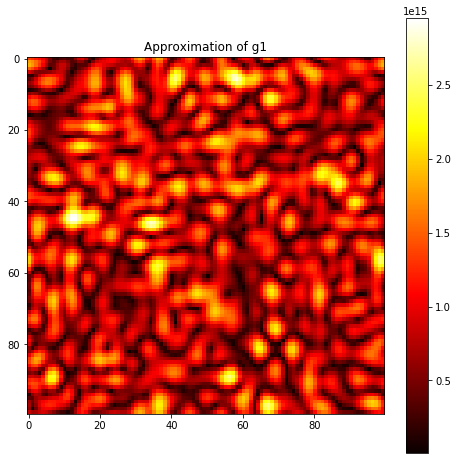

In [10]:

H = np.fft.fftshift(np.fft.fft2(h))
plt.figure(figsize=(8,8))
plt.title("G2 / H")
plt.imshow(np.abs(G2 / H), cmap='hot')
plt.colorbar()
plt.show()
g1_approx = np.fft.ifft2(G2 / H)
plt.figure(figsize=(8,8))
plt.title("Approximation of g1")
plt.imshow(np.abs(g1_approx), cmap='hot')
plt.colorbar()
plt.show()


3) Low pass filtering before deconvolution
---------------------
It can be seen in section 2 that the inverse filter works horribly. This is because noise is typically of high frequency, but the OPT goes down to basically 0 at high frequencies. This causes the noise to dominate the deconvoluted image. One way of fixing this is to apply a low pass filter before doing deconvolution.


In [11]:
def make_circ_mask(img_shape, radii):
    h, w = img_shape
    Y, X = np.ogrid[:h, :w]
    center = (int(w / 2), int(h / 2))
    dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)

    mask = dist_from_center <= radii
    mask = np.where(mask, 1., 0.)
    return mask


def filter_image(img_fourier, radii):
    mask = make_circ_mask(img_fourier.shape, radii)
    plt.figure(figsize=(15,15))
    plt.subplots_adjust(wspace=0.5)

    plt.subplot(241)
    plt.title(f"Low Pass Filter in Fourier Space\n(radii={radii})")
    plt.imshow(mask, cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    plt.subplot(242)
    plt.title("Filtered Image in Fourier Space")
    filtered_img_fourier = mask * img_fourier
    plt.imshow(np.log(np.abs(filtered_img_fourier)+1e-8), cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    filtered_img = np.fft.ifft2(filtered_img_fourier)
    plt.subplot(243)
    plt.title("Filtered Image in Coordinate Space")
    plt.imshow(np.abs(filtered_img), cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    plt.subplot(244)
    plt.title("Original Image")
    plt.imshow(g2, cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)
    plt.show()
    return np.abs(filtered_img)

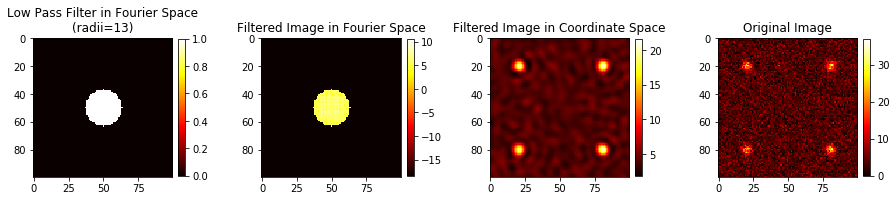

In [12]:
filtered_G2 = filter_image(G2, 13)

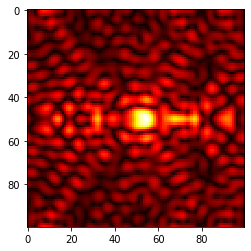

In [15]:
# now do the deconvolution
# why does it look nothing like the original image?
g1 = np.fft.ifft2(filtered_G2 / H)
plt.imshow(np.abs(g1), cmap='hot')

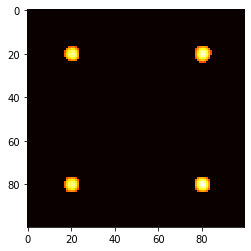

In [16]:
# try cutting off all the noise
height, width = filtered_G2.shape
for i in range(height):
    for j in range(width):
        if filtered_G2[i, j] < 10:
            filtered_G2[i, j] = 0
plt.imshow(filtered_G2, cmap='hot')

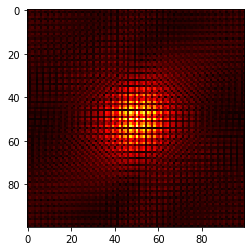

In [18]:
g1_binarized = np.fft.ifft2(filtered_G2 / H)
plt.imshow(np.abs(g1_binarized), cmap='hot')


4) Regularized Filter
-------------------
To suppress noise, use the regularized filter instead of the inverse filter, i.e.
$$G1 = \frac{H}{|H|^2 + \alpha |L|^2} G_2$$
where $\alpha$ is the Lagrange multiplier, $L$ is a high pass filter.
At higher frequencies, $H$ is very small, and this causes the noise to dominate. Instead, we add a high pass filter to the denominator so that at high frequencies the denominator remains large, thus suppressing the noise.

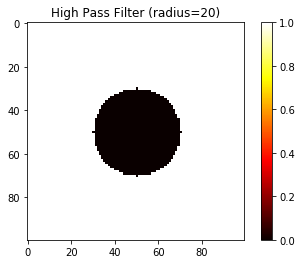

In [19]:
radius = 20
L = make_circ_mask((100, 100), radius)
L = -L + 1
plt.title(f"High Pass Filter (radius={radius})")
plt.imshow(L, cmap='hot')
plt.colorbar()



In [35]:
def regularized_filter(r, alpha):
    L = make_circ_mask((img_size, img_size), r)
    L = -L + 1
    plt.figure(figsize=(15,15))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    plt.subplot(131)
    plt.title(f"High Pass Filter (radius={radius})")
    plt.imshow(L, cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)


    G1 = H * G2 / (np.abs(H)**2 + alpha * (L*L))
    g1 = np.fft.fftshift(np.fft.ifft2(G1))
    plt.subplot(132)
    plt.title("Filtered Image")
    # print(H)
    plt.imshow(np.abs(g1), cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    plt.subplot(133)
    plt.title("Original Image")
    plt.imshow(g2, cmap='hot')
    plt.colorbar(fraction=0.045, pad=0.04)

    plt.show()

height, width = g2.shape
interactive_plot = interactive(regularized_filter, r=(0, height//2), alpha=(0., 3.))
output = interactive_plot.children[-1]
output.layout.height = '300px'
interactive_plot


interactive(children=(IntSlider(value=25, description='r', max=50), FloatSlider(value=1.5, description='alpha'…

5) Richardson-Lucy Algorithm
----------------------
Here we implement the richardson-lucy algorithm